Kelompok 21

1301180071 - Jose Yolanda Purba

1301180224 - M. Hanif Tri Atmaji


==============


Download dataset dari Kaggle

memanfaatkan API Kaggle, mohon ikuti langkah pada link ini:
[https://www.kaggle.com/general/74235](https://www.kaggle.com/general/74235)

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files # upload token API Kaggle
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"josepurba","key":"860bf887478ed19c2c10a5f9533dfe64"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download 'andrewmvd/hard-hat-detection'

100% 1.22G/1.22G [00:05<00:00, 245MB/s]
100% 1.22G/1.22G [00:05<00:00, 235MB/s]


Unzip/ekstrak dataset

In [ ]:
import zipfile
local_zip = 'hard-hat-detection.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('hard-hat-detection')
zip_ref.close()

Import library yang dibutuhkan

In [ ]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from shutil import copyfile
from xml.dom.minidom import parse

Buat direktori untuk gambar dan label yang telah diekstrak

In [ ]:
!mkdir -p Dataset/labels
!mkdir -p Dataset/images

Deklarasi kelas yang akan dideteksi

In [ ]:
classes = ['helmet', 'head', 'person']

Fungsi untuk mengkonversi anotasi PascalVOC ke YOLO

In [ ]:
def convert_annot(size, box):
    x1 = int(box[0])
    y1 = int(box[1])
    x2 = int(box[2])
    y2 = int(box[3])

    dw = np.float32(1. / int(size[0]))
    dh = np.float32(1. / int(size[1]))

    w = x2 - x1
    h = y2 - y1
    x = x1 + (w / 2)
    y = y1 + (h / 2)

    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    
    return [x, y, w, h]

Fungsi untuk menyimpan anotasi YOLO ke dalam file txt

In [ ]:
def save_txt_file(img_jpg_file_name, size, img_box):
    save_file_name = '/content/Dataset/labels/' +  img_jpg_file_name + '.txt'
    print(save_file_name)
    
    with open(save_file_name ,'a+') as file_path:
        for box in img_box:
            cls_num = classes.index(box[0])
            new_box = convert_annot(size, box[1:])
            file_path.write(f"{cls_num} {new_box[0]} {new_box[1]} {new_box[2]} {new_box[3]}\n")

        file_path.flush()
        file_path.close()

Fungsi untuk mengekstrak anotasi dari file xml (PascalVOC)

In [ ]:
def get_xml_data(file_path, img_xml_file):
    img_path = file_path + '/' + img_xml_file + '.xml'
    dom = parse(img_path)
    root = dom.documentElement
    img_name = root.getElementsByTagName("filename")[0].childNodes[0].data
    img_size = root.getElementsByTagName("size")[0]
    objects = root.getElementsByTagName("object")
    img_w = img_size.getElementsByTagName("width")[0].childNodes[0].data
    img_h = img_size.getElementsByTagName("height")[0].childNodes[0].data
    img_c = img_size.getElementsByTagName("depth")[0].childNodes[0].data
   
    img_box = []
    for box in objects:
        cls_name = box.getElementsByTagName("name")[0].childNodes[0].data
        x1 = int(box.getElementsByTagName("xmin")[0].childNodes[0].data)
        y1 = int(box.getElementsByTagName("ymin")[0].childNodes[0].data)
        x2 = int(box.getElementsByTagName("xmax")[0].childNodes[0].data)
        y2 = int(box.getElementsByTagName("ymax")[0].childNodes[0].data)
        img_jpg_file_name = img_xml_file + '.jpg'
        img_box.append([cls_name, x1, y1, x2, y2])
  

    save_txt_file(img_xml_file, [img_w, img_h], img_box)

Mengkonversi semua anotasi PascalVOC (xml) ke bentuk YOLO (txt)

In [ ]:
files = os.listdir('hard-hat-detection/annotations')
for file in files:
    print("file name: ", file)
    file_xml = file.split(".")
    print(file_xml[0])
    get_xml_data('hard-hat-detection/annotations', file_xml[0])

Streaming output truncated to the last 5000 lines.
hard_hat_workers3502
/content/Dataset/labels/hard_hat_workers3502.txt
file name:  hard_hat_workers2840.xml
hard_hat_workers2840
/content/Dataset/labels/hard_hat_workers2840.txt
file name:  hard_hat_workers4679.xml
hard_hat_workers4679
/content/Dataset/labels/hard_hat_workers4679.txt
file name:  hard_hat_workers4618.xml
hard_hat_workers4618
/content/Dataset/labels/hard_hat_workers4618.txt
file name:  hard_hat_workers2921.xml
hard_hat_workers2921
/content/Dataset/labels/hard_hat_workers2921.txt
file name:  hard_hat_workers3440.xml
hard_hat_workers3440
/content/Dataset/labels/hard_hat_workers3440.txt
file name:  hard_hat_workers3681.xml
hard_hat_workers3681
/content/Dataset/labels/hard_hat_workers3681.txt
file name:  hard_hat_workers417.xml
hard_hat_workers417
/content/Dataset/labels/hard_hat_workers417.txt
file name:  hard_hat_workers4141.xml
hard_hat_workers4141
/content/Dataset/labels/hard_hat_workers4141.txt
file name:  hard_hat_worke

Split dataset menjadi data train, val, and test

In [ ]:
from sklearn.model_selection import train_test_split
image_list = os.listdir('/content/hard-hat-detection/images')
train_list, test_list = train_test_split(image_list, test_size=0.2, random_state=42)
val_list, test_list = train_test_split(test_list, test_size=0.5, random_state=42)
print('total =',len(image_list))
print('train :',len(train_list))
print('val   :',len(val_list))
print('test  :',len(test_list))

total = 5000
train : 4000
val   : 500
test  : 500


Fungsi untuk mengcopy data gambar/label ke foldernya masing-masing (train/val/test)

In [ ]:
def copy_data(file_list, img_labels_root, imgs_source, mode):

    root_file = Path( '/content/Dataset/images/'+  mode)
    if not root_file.exists():
        print(f"Path {root_file} does not exit, making a new one")
        os.makedirs(root_file)

    root_file = Path('/content/Dataset/labels/' + mode)
    if not root_file.exists():
        print(f"Path {root_file} does not exit, making a new one")
        os.makedirs(root_file)

    for file in file_list:               
        img_name = file.replace('.png', '')        
        img_src_file = imgs_source + '/' + img_name + '.png'        
        label_src_file = img_labels_root + '/' + img_name + '.txt'

        DICT_DIR = '/content/Dataset/images/'  + mode
        img_dict_file = DICT_DIR + '/' + img_name + '.png'

        copyfile(img_src_file, img_dict_file)

        DICT_DIR = '/content/Dataset/labels/' + mode
        img_dict_file = DICT_DIR + '/' + img_name + '.txt'
        copyfile(label_src_file, img_dict_file)

Mengcopy data gambar/label ke foldernya masing-masing (train/val/test)

In [ ]:
copy_data(train_list, '/content/Dataset/labels', '/content/hard-hat-detection/images', "train")
copy_data(val_list,   '/content/Dataset/labels', '/content/hard-hat-detection/images', "val")
copy_data(test_list,  '/content/Dataset/labels', '/content/hard-hat-detection/images', "test")

Path /content/Dataset/images/train does not exit, making a new one
Path /content/Dataset/labels/train does not exit, making a new one
Path /content/Dataset/images/val does not exit, making a new one
Path /content/Dataset/labels/val does not exit, making a new one
Path /content/Dataset/images/test does not exit, making a new one
Path /content/Dataset/labels/test does not exit, making a new one


Clone repo YOLOv5 dari Github

In [ ]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 10504, done.
remote: Total 10504 (delta 0), reused 0 (delta 0), pack-reused 10504
Receiving objects: 100% (10504/10504), 10.72 MiB | 32.00 MiB/s, done.
Resolving deltas: 100% (7254/7254), done.
/content/yolov5


Buat file yaml untuk konfigurasi YOLO

In [ ]:
import yaml

dict_file = {'train':'/content/Dataset/images/train',
            'val': '/content/Dataset/images/val',
            'nc' : '3',
            'names' : ['helmet', 'head', 'person']}

with open('/content/yolov5/data/hard_head.yaml', 'w+') as file:
    documents = yaml.dump(dict_file, file)


***===== PENTING =====***

***sangat mungkin bagi anda untuk perlu menjalankan (run) cell ini dua kali karena run pertama bisa jadi mengupdate modul yg dibutuhkan. Tolong perhatikan pesan output sebelum melanjutkan ke cell berikutnya***

In [ ]:
!python train.py --img 416 --batch 32 --epochs 30 --data data/hard_head.yaml --cfg models/yolov5s.yaml --weights yolov5s.pt

train: weights=yolov5s.pt, cfg=models/yolov5s.yaml, data=data/hard_head.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=30, batch_size=32, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.0-188-g80473a6 torch 1.10.0+cu111 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0,

Validasi akurasi model

***===== PENTING =====***

***jika terjadi error, harap lihat output dari cell sebelumnya (train model) dan cek di mana hasil training disimpan (folder exp/exp2/exp3), angka di belakang exp bisa berubah. jika berbeda dengan code di bawah harap dirubah terlebih dahulu *** 

In [ ]:
!python val.py --weights runs/train/exp2/weights/best.pt --data data/hard_head.yaml --img 640

val: data=data/hard_head.yaml, weights=['runs/train/exp2/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.0-188-g80473a6 torch 1.10.0+cu111 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model Summary: 213 layers, 7018216 parameters, 0 gradients
val: Scanning '/content/Dataset/labels/val.cache' images and labels... 500 found, 0 missing, 0 empty, 0 corrupted: 100% 500/500 [00:00<?, ?it/s]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100% 16/16 [00:10<00:00,  1.58it/s]
                 all        500       2539      0.617      0.583      0.622      0.392
              helmet        500       1979      0.945      0.912      0.964      0.614
                head        500        521      0.905    

Deteksi dan gambar bounding box ke semua data test

***===== PENTING =====***

***jika terjadi error, harap lihat output dari cell TRAIN MODEL dan cek di mana hasil training disimpan (folder exp/exp2/exp3), angka di belakang exp bisa berubah. jika berbeda dengan code di bawah harap dirubah terlebih dahulu ***

In [ ]:
!python detect.py --source /content/Dataset/images/test --weights runs/train/exp2/weights/best.pt --conf 0.25

detect: weights=['runs/train/exp2/weights/best.pt'], source=/content/Dataset/images/test, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-188-g80473a6 torch 1.10.0+cu111 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model Summary: 213 layers, 7018216 parameters, 0 gradients
image 1/500 /content/Dataset/images/test/hard_hat_workers1014.png: 640x640 11 heads, Done. (0.015s)
image 2/500 /content/Dataset/images/test/hard_hat_workers102.png: 640x640 3 helmets, Done. (0.015s)
image 3/500 /content/Dataset/images/test/hard_hat_workers1032.png: 640x640 11 helmets, Done. (0.015s)
image 4/500 /content/Dataset/images/test/hard_hat_workers1040.png: 640x640 

Tampilkan 1 contoh gambar yang telah dideteksi dan digambar bounding boxnya

In [ ]:
from IPython.display import Image

<function matplotlib.pyplot.show>

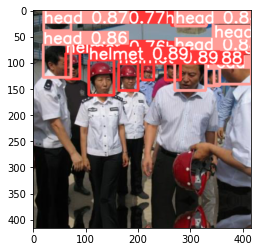

In [ ]:
from glob import glob
import matplotlib.pyplot as plt
testfiles = glob('runs/detect/exp/*')
#138
img = plt.imread(testfiles[156]) 
plt.imshow(img)
plt.show